In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch.cuda
from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch.utils.data import Dataset, DataLoader,random_split
from utils import *
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import pickle
import whisper
import pytorch_lightning as pl
from torch import nn
import torch.nn.functional as F
import random

# DATA ANALYSIS

In [ ]:
df = pd.read_csv('dataset/EDOS 1M.csv')

### The first 20 entries are

In [ ]:
df.head(20)

### Any empty documents?

In [ ]:
n_empty = (df.loc[:, 'uttr'].apply(len) <= 0).sum()
print(f'There are {n_empty} empty documents.')

### Any NA values?

In [ ]:
df.isna().sum()

## SIMPLE STATS

In [ ]:
n_features = df.shape[1]
n_docs = df.shape[0]
print(f'{n_docs} entries with {n_features} features each')

### How many emotions?

In [ ]:
emotions = df.loc[:, 'eb+_emot']
unique_emotions, count_ = np.unique(emotions, return_counts=True)
n_emotions = len(unique_emotions)
print(f'{n_emotions} emotions:')
print(unique_emotions)

In [ ]:
fig = plt.figure(1, figsize=(12, 6))
plt.bar(unique_emotions, count_)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Balance dataset w.r.t. emotion count

In [ ]:
print(f'Least frequent emotion: {unique_emotions[np.argmin(count_)]} with {np.min(count_)} occurrences')
print(f'Most frequent emotion: {unique_emotions[np.argmax(count_)]} with {np.max(count_)} occurrences')

In [ ]:
balance_df = []
least_freq = np.min(count_)
generator = np.random.default_rng(0)

for emo in unique_emotions:
    group = df[df.loc[:, 'eb+_emot'] == emo].copy(deep=True).reset_index(drop=True)
    group_size = len(group)
    if group_size == least_freq:
        balance_df.append(group)
        continue
    select_random = generator.choice(range(group_size), size=group_size - least_freq, replace=False)
    group.drop(select_random, axis=0, inplace=True)
    assert len(group) == least_freq
    balance_df.append(group.copy())

balance_df = pd.concat(balance_df)

In [ ]:
print(f'Dataset is balanced with {group.shape[0]} entries x {n_emotions} emotions = {balance_df.shape[0]} entries total')

In [ ]:
emotions = balance_df.loc[:, 'eb+_emot']
unique_emotions = emotions.unique()
unique_emotions, count_ = np.unique(emotions, return_counts=True)
fig = plt.figure(1, figsize=(12, 6))
plt.bar(unique_emotions, count_)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
df = balance_df.copy(deep=True).reset_index()
df.to_pickle('./dataset/EDOS_1M_balanced.pkl')

### label_confidence distribution

In [ ]:
def parse_emotions():
    for emo in unique_emotions:
        e = df[df.loc[:, 'eb+_emot'] == emo].loc[:, 'label_confidence'].to_numpy(dtype=np.float32)
        yield emo, e


fig = plt.figure(figsize=(24, 10))
e_values = [e for _, e in parse_emotions()]
plt.title('label_confidence per emotion')
plt.boxplot(e_values)
plt.xticks(range(1, n_emotions + 1), unique_emotions)
plt.xticks(rotation=90)
plt.show()


In [ ]:
list_stats = []
for emo, e in parse_emotions():
    list_stats.append(pd.DataFrame([[np.mean(e), np.std(e)]], columns=['mean', 'std'], index=[emo]))

df_mean_std = pd.concat(list_stats)
df_mean_std = df_mean_std.sort_values(by='mean')

In [ ]:
# average utterance length
mean_length_u = df.loc[:, 'uttr'].apply(len).mean()
print(f'avg utterance length is {mean_length_u:.2f}')

In [ ]:
# average utterance length per emotion
def parse_utterances():
    for emo in unique_emotions:
        yield df[df.loc[:, 'eb+_emot'] == emo].loc[:, 'uttr'].apply(len).mean()


u_values = [u for u in parse_utterances()]
sort_idx = np.argsort(u_values)
u_values = np.sort(u_values)

In [ ]:
fig = plt.figure(figsize=(14, 8))
t = np.array([i for i in range(n_emotions)])
# Plotting mean label confidence
mm = df_mean_std.loc[unique_emotions[sort_idx], 'mean']
plt.bar(t - 0.2, mm, width=0.4, label='Avg confidence')

scaled_u_values = u_values / np.max(u_values)

plt.bar(t + 0.2, scaled_u_values, width=0.4, label='Avg utterance length [millions]')

plt.title('Comparison of avg confidence and avg utterance length per emotion')
plt.xticks(range(n_emotions), unique_emotions[sort_idx], rotation=90)  # Set the emotion labels on the x-axis

# Adding legend
plt.legend()

# Display the plot
plt.show()

## CORRELATIONS


In [ ]:
df_length_to_coeff = pd.concat((df.loc[:, 'uttr'].apply(len), df.loc[:, 'label_confidence']), axis=1)
plt.figure(figsize=(8, 6))
corr_length_to_coeff = df_length_to_coeff.corr('spearman')
sns.heatmap(corr_length_to_coeff, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmax=1.0, vmin=-1.0)
plt.title('Correlation Matrix between length of utterance and confidence level')
plt.show()

## CLUSTER
We first produce embedding using the glove-twitter 

In [ ]:
import gensim.downloader as api
model_twitter = api.load("glove-twitter-50")

In [ ]:
dataset = balance_df.loc[:, 'uttr'].to_numpy()
labels = balance_df.loc[:, 'eb+_emot'].to_numpy()
import re

pattern1 = re.compile('\n')
pattern2 = re.compile('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}')
test = np.vectorize(lambda x: re.sub(pattern2, '', re.sub(pattern1, ' ', x)))(dataset)
tokens = [x.strip().lower().split(' ') for x in test]


def vectorize(tokens_, use_sum=True):
    global model_twitter
    vectors = np.zeros((len(tokens_), 50))
    for i in range(0, len(tokens_)):
        embs = [model_twitter.get_vector(token) for token in tokens_[i] if token in model_twitter]
        if use_sum:
            vectors[i] = np.sum(embs, axis=0)
        else:
            vectors[i] = np.mean(embs, axis=0)
    return vectors


In [ ]:
embeddings = vectorize(tokens)

### We use the umap library to plot the embedding s

In [ ]:
import umap

reducer = umap.UMAP(n_components=3, n_neighbors=5)

In [ ]:
to_plot = reducer.fit_transform(embeddings)

In [ ]:
df_sns = balance_df.copy()
dict_emotion_to_category = {key: value for key, value in zip(unique_emotions, range(len(unique_emotions)))}
dict_category_to_emotion = {key: value for key, value in zip(range(len(unique_emotions)), unique_emotions)}

In [ ]:
# We use plotly to produce an interactive 3D plot
import plotly.express as px
limit = 30000 # a few of them are presented
colors = sns.color_palette(n_colors=len(labels[:limit]))
colors = [colors[dict_emotion_to_category[x]] for x in labels[:limit]]

df = pd.DataFrame({'x': to_plot[:limit, 0], 'y': to_plot[:limit, 1], 'z': to_plot[:limit, 2], 'labels': labels[:limit]})
fig = px.scatter_3d(df, x='x', y='y', z='z', color='labels')

fig.show()

In [ ]:
translated_labels = [dict_emotion_to_category[x] for x in labels]
X_train, X_test, y_train, y_test = train_test_split(to_plot, translated_labels, stratify=translated_labels, test_size=0.3, random_state=12, shuffle=True)

We perform clustering using K-Means and test if a simple clustering algorithm is able to cluster text 

In [ ]:
from sklearn.cluster import KMeans
cluster = KMeans(n_clusters=len(dict_category_to_emotion))
cluster = cluster.fit(X_train, y_train)

In [ ]:
train_f = cluster.predict(X_train)
df_cluster = pd.DataFrame({
    'predicted_label': train_f,
    'label' : translated_labels
})

In [ ]:
cluster_table = {}
for name, group in df_cluster.groupby('predicted_label'):
    uniq_c , count_c = np.unique(group['label'].to_numpy(), return_counts=True)
    index = np.argmax(count_c)
    label_assigned = dict_category_to_emotion[uniq_c[index]]
    print(f'Label {name} assigned {label_assigned}')
    cluster_table[name] = uniq_c[index]

In [ ]:
def compute_metrics_cluster(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1_score_ = f1_score(y_true, y_pred, average='weighted')
    print(f'TEST SET: accuracy: {accuracy} ; f1 score: {f1_score_}')

In [ ]:
y_pred = cluster.predict(X_test)
y_pred = [cluster_table[y] for y in y_pred]
compute_metrics_cluster(y_test, y_pred)

In [ ]:
fig = plt.figure(figsize=(5, 5))
y_pred_translated = [dict_category_to_emotion[y] for y in y_pred]
y_pred_translated_unique, y_pred_translated_count = np.unique(y_pred_translated, return_counts=True)
plt.bar(y_pred_translated_unique, y_pred_translated_count)
plt.xticks(range(len(y_pred_translated_unique)), y_pred_translated_unique, rotation=90)
plt.tight_layout()
plt.show()

## SIMPLE CLASSIFIER
We use a simple RandomForestClassifier to classify the embedded utterances 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_jobs=8, random_state=99)
classifier = classifier.fit(X_train, y_train)

In [ ]:
y_pred = classifier.predict(X_test)
compute_metrics_cluster(y_test, y_pred)

In [ ]:
y_pred_translated = [dict_category_to_emotion[y] for y in y_pred]
fig = plt.figure(figsize=(10, 10))
y_pred_translated = [dict_category_to_emotion[y] for y in y_pred]
y_pred_translated_unique, y_pred_translated_count = np.unique(y_pred_translated, return_counts=True)
plt.bar(y_pred_translated_unique, y_pred_translated_count)
plt.xticks(range(len(y_pred_translated_unique)), y_pred_translated_unique, rotation=90)
plt.tight_layout()
plt.show()

# BERT CLASSIFIER
We use the bert base uncased model to perform Text-Emotion Recognition. We use this pre-trained model to extract features from the text from the hidden layers. We define then a simple multi layer perceptron to classify the input text


In [2]:
PRETRAINED_MODEL_NAME = "bert-base-uncased"
BATCH_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

We use the tokenizer of bert-base-uncased.

In [3]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

We get the data from the balanced edos dataset. 
(The `get_edos_dataset_balanced` function was moved in a python file called `utils.py)

In [4]:
groups, labels, confidence = get_edos_dataset_balanced()

We define the dictionary that will be used to pass from emotions to categories and viceversa

In [5]:
unique = np.unique(labels.flatten())
emotions_to_category = {key: value for key, value in zip(unique, range(len(unique)))}
category_to_emotion = {key: value for key, value in zip(range(len(unique)), unique)}
labels = np.vectorize(lambda x: emotions_to_category[x])(labels)

We generate TRAIN, VALIDATION AND TESTING DATA using the stratify option to get balanced datasets

In [6]:
seed = 0
(X_train, y_train), (X_val, y_val), (X_test, y_test), (Z_train, Z_val, Z_test) = split(groups.flatten(),
                                                                                       labels.flatten(), seed,
                                                                                       confidence.flatten())
print('TRAIN SHAPE:', X_train.shape)
print('TEST SHAPE:', X_test.shape)
print('VALIDATION SHAPE:', X_val.shape)

TRAIN SHAPE: (56,)
TEST SHAPE: (30,)
VALIDATION SHAPE: (14,)


TRAIN, TEST, DATA are first stored in a custom `Dataset` object (defined in `utils.py`)

In [7]:
train_dataset = OurDataset(X_train, y_train, Z_train)
test_dataset = OurDataset(X_test, y_test, Z_test)
val_dataset = OurDataset(X_val, y_val, Z_val)

The collate function allows us to process batched data using the bert-base-uncased tokenizer and build batches of size BATCHSIZE and genertae the corresponding dataloaders required to train and validate our model

In [8]:
def collate_fn(batch):
    global tokenizer
    x, y, z = [], [], []
    for x1, y1, z1 in batch:
        x.append(x1)
        y.append(y1)
        z.append(z1)
    batch = tokenizer(x, padding=True, return_tensors='pt')
    y = torch.as_tensor(y)
    z = torch.as_tensor(z, dtype=torch.float32)
    return batch, y, z

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

We define our model which takes output hidden states features of the pre-trained model bert-base-uncased and feed them to a multi layer perceptron to make emotion classification. 
La struttura del nostro modello è ispirata da un articolo su kaggle chiamato: Utilizing Transformer Representations Efficiently.
https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently.
This approach complements the outputs of the hidden states of the pretrained model by focusing primarily on the intermediate layers, which, according to the article, demonstrate greater specialization in the contextual representation of the input text. The exclusive use of the final layers may not be optimal. In addition, there is a model in which only the final four layers are concatenated, but here we present only one of them. We found no substantial differences in performance between the two.

In [10]:
class WeightedPooling(Agglomerate):
    def __init__(self, device, start_layer=4, name='bert-base-uncased'):
        super(WeightedPooling, self).__init__(device)
        config = AutoConfig.from_pretrained(name)
        config.update({"output_hidden_states": True})
        self.encoder = AutoModel.from_pretrained(name, config=config)
        self.encoder.to(device)
        self.encoder.eval()
        for param in self.encoder.parameters(recurse=True):
            param.requires_grad = False
        self.start_layer = start_layer

    def __call__(self, batch):
        with torch.no_grad():
            x = self.encoder(batch['input_ids'].to(self.device),
                             batch['attention_mask'].to(self.device))  # TODO: check against ** batch
            hidden_states = torch.stack(x["hidden_states"])
            hidden_states = hidden_states[self.start_layer:, :, :, :]
        return hidden_states


class EmotionClassifierWeightedPooling(nn.Module):
    def __init__(self,
                 output_size,
                 device,
                 hidden_layers,
                 start_layer,
                 activation_fn=nn.ReLU,
                 dropout_value=0.,
                 total_hidden_states=13
                 ):
        super(EmotionClassifierWeightedPooling, self).__init__()

        self.start_layer = start_layer
        self.classification = nn.Sequential(
        )
        for i in range(len(hidden_layers)):
            curr = hidden_layers[i]
            if i == 0:
                self.classification.append(nn.LazyLinear(curr))
                self.classification.append(activation_fn())
                if dropout_value > 0:
                    self.classification.append(nn.Dropout(dropout_value))
                continue
            prev = hidden_layers[i - 1]
            self.classification.append(nn.Linear(prev, curr))
            self.classification.append(activation_fn())
            if dropout_value > 0:
                self.classification.append(nn.Dropout(dropout_value))

        self.classification.append(nn.Linear(hidden_layers[-1], output_size))
        # self.classification.append(nn.Softmax(dim=-1))

        self.device = device

        # wieght # 64, 61, 768
        self.layer_weight = nn.Parameter(
            torch.full(size=(total_hidden_states - start_layer, 1, 1, 1), fill_value=1, dtype=torch.float32,
                       requires_grad=True))

    def forward(self, hidden_states):
        with torch.no_grad():
            weight_factor = self.layer_weight.expand(hidden_states.size())
            weighted_average = (weight_factor * hidden_states).sum(dim=0) / self.layer_weight.sum()
        return self.classification(weighted_average[:, 0])



We define here our trainer which takes the pretrained model and the additional layers to perform emotion classification

In [11]:
from torchsummary import summary
import os



class Trainer:
    def __init__(self,
                 model: EmotionClassifierWeightedPooling,
                 agglomerate: Agglomerate,
                 model_name: str,
                 device,
                 dataloaders: tuple[DataLoader, DataLoader],
                 optimizer=torch.optim.AdamW,
                 scheduler=None,
                 lr: float = 1e-3,
                 output_dir: str = './RESULTS',
                 patience: int = 10,
                 clipping_norm=0.1,
                 verbose=0,
                 top_n=5
                 ):
        self.model_name = model_name
        self.agglomerate = agglomerate
        self.device = device
        self.output_dir = output_dir
        self.top_n = top_n

        self.model = model
        self.model.to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optimizer(self.model.parameters(), lr=lr)
        self.scheduler = scheduler
        self.verbose = verbose
        self.train_loader, self.val_loader = dataloaders

        self.train_loss = []
        self.train_accuracy = []
        self.train_f1_score = []
        self.validation_loss = []
        self.validation_accuracy = []
        self.validation_f1_score = []
        self.validation_is_in_top_5 = []

        self.early_stopper = EarlyStopping(patience)
        self.clipping_norm = clipping_norm

        if not os.path.exists(output_dir):
            os.mkdir(output_dir)

    def process_data(self, batch):
        batch = self.agglomerate(batch)
        return self.model.forward(batch)

    def print_architecture(self, batch_size=64):  #TODO: NOT WORKING
        print(summary(self.model.classification, input_size=(3072,), batch_size=batch_size, device=self.device))

    def reset_params(self):
        self.train_loss = []
        self.train_accuracy = []
        self.train_f1_score = []
        self.validation_loss = []
        self.validation_accuracy = []
        self.validation_f1_score = []
        self.validation_is_in_top_5 = []

    def draw_training_metrics(self, save=True, format='pdf', figsize=(16, 8), step=1):
        if len(self.train_loss) == 0:
            return
        fig, axs = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle(f'Training metrics')
        axs[0].plot(self.train_loss, label='Train')
        axs[0].plot(self.validation_loss, label='Validation')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].set_xticks(np.arange(0, len(self.train_loss), step))
        axs[0].legend()

        axs[1].plot(self.train_accuracy, label='Train')
        axs[1].plot(self.validation_accuracy, label='Validation')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].set_xticks(np.arange(0, len(self.train_accuracy), step))
        axs[1].legend()

        axs[2].plot(self.train_f1_score, label='Train')
        axs[2].plot(self.validation_f1_score, label='Validation')
        axs[2].set_xlabel('Epochs')
        axs[2].set_ylabel('F1 Score')
        axs[2].set_xticks(np.arange(0, len(self.train_f1_score), step))
        axs[2].legend()

        plt.tight_layout()
        if save:
            plt.savefig(f'{self.output_dir}/{self.model_name}_train_metrics.{format}', bbox_inches='tight')
        plt.show()

    def draw_top_5(self, save=True, format='pdf', figsize=(16, 8), step=1):
        fig = plt.figure(figsize=figsize)
        plt.plot(self.validation_is_in_top_5)
        plt.xlabel('Epochs')
        plt.tight_layout()
        if save:
            plt.savefig(f'{self.output_dir}/{self.model_name}_top_5.{format}', bbox_inches='tight')
        plt.show()

    def train_model(self, epochs):
        self.reset_params()
        loader_length = len(self.train_loader)
        for ep in range(1, epochs + 1):
            print('#' * 20, ep, '#' * 20)
            self.model.train()
            loss_ep: float = 0.
            accuracy_ep: float = 0.
            f1_score_ep: float = 0.
            for batch, labels, confidence, in tqdm(self.train_loader):
                out = self.process_data(batch)
                self.optimizer.zero_grad()
                loss = self.loss_fn(out, labels.to(self.device))
                loss.backward()
                if self.clipping_norm > 0:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clipping_norm)
                self.optimizer.step()
                loss_ep += loss.item()
                with torch.no_grad():
                    a, f1 = compute_metrics(labels, out)
                    accuracy_ep += a
                    f1_score_ep += f1
            loss_ep /= loader_length
            accuracy_ep /= loader_length
            f1_score_ep /= loader_length
            self.train_loss.append(loss_ep)
            self.train_accuracy.append(accuracy_ep)
            self.train_f1_score.append(f1_score_ep)
            print(f'TRAIN LOSS: {loss_ep:.5f} ; ACCURACY: {accuracy_ep:.5f} ; F1: {f1_score_ep:.5f}')
            if self.val_loader is not None:
                if self.validate():
                    break

    def validate(self):
        global tokenizer, category_to_emotion
        self.model.eval()
        with torch.no_grad():
            loss_val = 0
            accuracies = 0
            f1_scores = 0
            length_val_dataloader = len(self.val_loader)
            top_5_ep = 0.
            for idx, (batch, labels, confidence) in enumerate(self.val_loader):
                out = self.process_data(batch)
                loss = self.loss_fn(out, labels.to(self.device))
                loss_val += loss.item()
                out = nn.functional.softmax(out, dim=-1)
                ac, f1 = compute_metrics(labels, out)
                accuracies += ac
                f1_scores += f1
                top_5_ep += top(labels, out)
                if self.verbose:
                    if idx == length_val_dataloader - 1:
                        input_, y_true, y_pred, c_true, c_pred, top_5_emotions = decode(batch['input_ids'], labels, out,
                                                                                        confidence, tokenizer,
                                                                                        category_to_emotion, self.top_n)

            loss_val /= length_val_dataloader
            accuracies /= length_val_dataloader
            f1_scores /= length_val_dataloader
            top_5_ep /= length_val_dataloader
            self.validation_loss.append(loss_val)
            self.validation_accuracy.append(accuracies)
            self.validation_f1_score.append(f1_scores)
            self.validation_is_in_top_5.append(top_5_ep)
            print(
                f'VAL   LOSS: {loss_val:.5f} ; ACCURACY: {accuracies:.5f} ; F1: {f1_scores:.5f} ; top {self.top_n}: {top_5_ep:.5f}')
            if self.verbose:
                print('INPUT:', input_.replace('[PAD]', '').rstrip())
                print('TRUE LABEL:', y_true, 'conf:', f'{c_true:.5f}')
                print('PREDICTED_LABEL', y_pred, 'conf', f'{c_pred:.5f}')
                if top_5_emotions is not None:
                    print(f'TOP {self.top_n}: {list(reversed(top_5_emotions))}')
            break_, save_ = self.early_stopper(accuracies)
            if save_:
                torch.save(self.model.state_dict(), f'{self.output_dir}/{self.model_name}.pt')
        return break_


def load_model(model, path: str):
    if not path.endswith('.pt'):
        path += '.pt'
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))





In [12]:
OUTPUT_SIZE = len(emotions_to_category)
HIDDEN_LAYERS = [128, 64]
# this is our model, we start at the 4-th layer
model_edos = EmotionClassifierWeightedPooling(
    output_size=OUTPUT_SIZE,
    device=DEVICE,
    hidden_layers=HIDDEN_LAYERS,
    start_layer=4
).to(DEVICE)
agglomerate_edos = WeightedPooling(device=DEVICE, start_layer=4)

/Users/marziolunghi/Documents/GitHub/ATML-NLP/.venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [13]:
model_name = 'model_edos'
output_size = len(emotions_to_category)
output_dir_edos = './RESULTS'
dataloaders = train_dataloader, val_dataloader
trainer = Trainer(
    model_edos,
    agglomerate=agglomerate_edos,
    model_name=model_name,
    device=DEVICE,
    dataloaders=dataloaders,
    verbose=1,
    output_dir=output_dir_edos
)

In [14]:
if not os.path.exists(f'{output_dir_edos}/{model_name}.pt'):
    trainer.train_model(20)

We present the following training metrics: (1) cross entroy loss; (2) accuracy; (3) f1 score 
The model has an early stopping mechanism which monitor the validation loss

In [15]:
trainer.draw_training_metrics(save=False, figsize=(18, 6))

We present here another metric, we check if for each observation in the validation the associated label is present in the first k prediction sorted by probability, by default k=5 since we have a total of 41 emotions

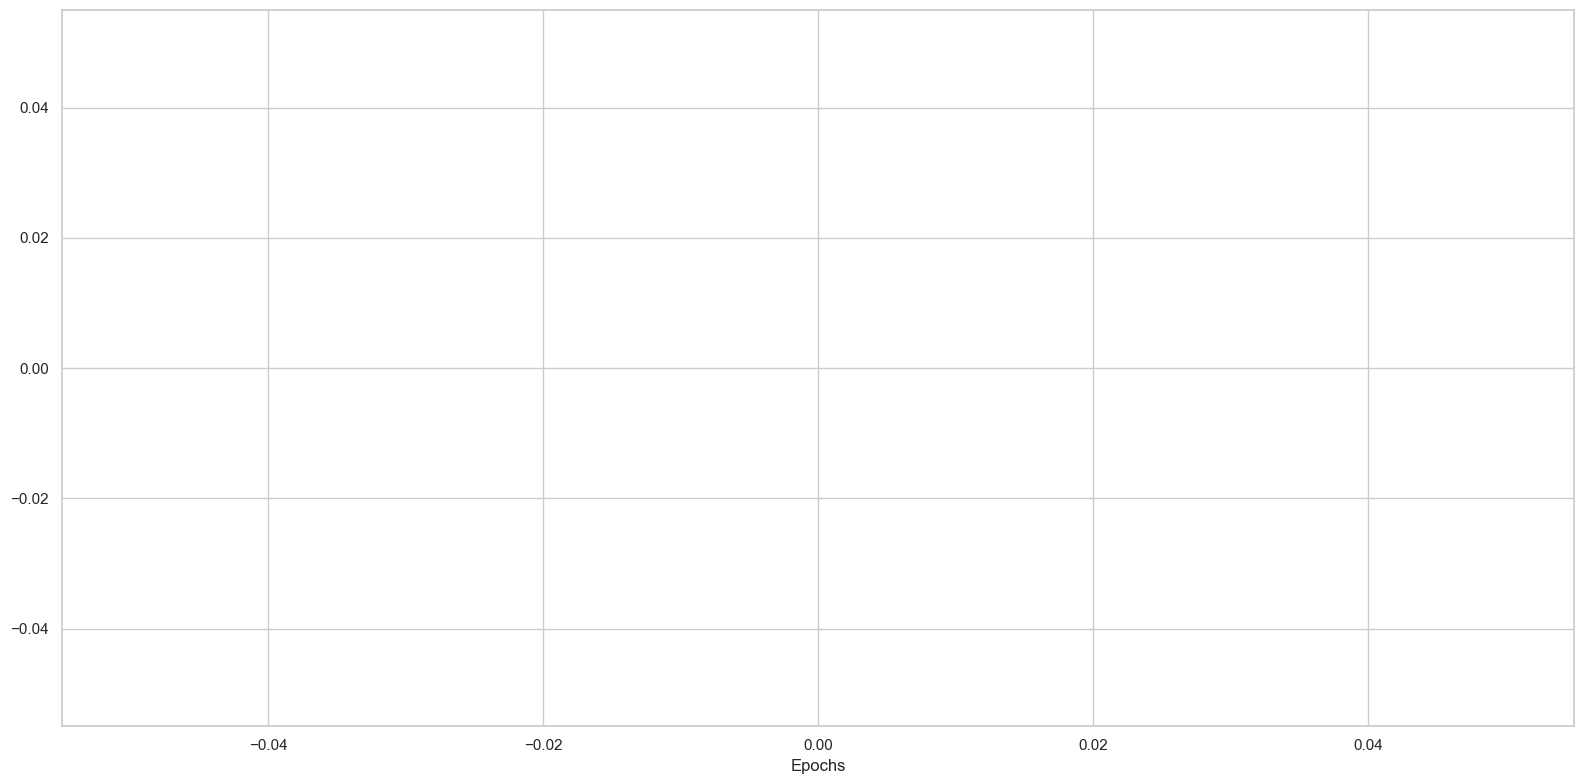

In [16]:
trainer.draw_top_5(save=False)

In [17]:
# we load the best model
load_model(model_edos, f'{output_dir_edos}/{model_name}.pt')
model_edos.to(DEVICE)

EmotionClassifierWeightedPooling(
  (classification): Sequential(
    (0): LazyLinear(in_features=0, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=41, bias=True)
  )
)

We compute the testing metrics: (1) accuracy ; (2) f1 score; (3) top_k score

In [67]:
# y_true, y_pred, accuracies, f1, top_n
edos_metrics = test_edos_text_model(model_edos,
                                    agglomerate_edos,
                                    test_dataloader,
                                    category_to_emotion)

  0%|          | 0/1 [00:00<?, ?it/s]

In [74]:
def print_mean_metrics(metrics):
    print(f'MEAN ACCURACIES : {np.mean(metrics[2])}')
    print(f'MEAN F1 SCORE   : {np.mean(metrics[3])}')
    print(f'MEAN TOP 5 SCORE: {np.mean(metrics[-1])}')


x_edos = list(map(lambda x: category_to_emotion[x], np.concatenate(edos_metrics[0], axis=0)))
y_edos = list(map(lambda x: category_to_emotion[x], np.concatenate(edos_metrics[1], axis=0)))


We present here the confusion matrix

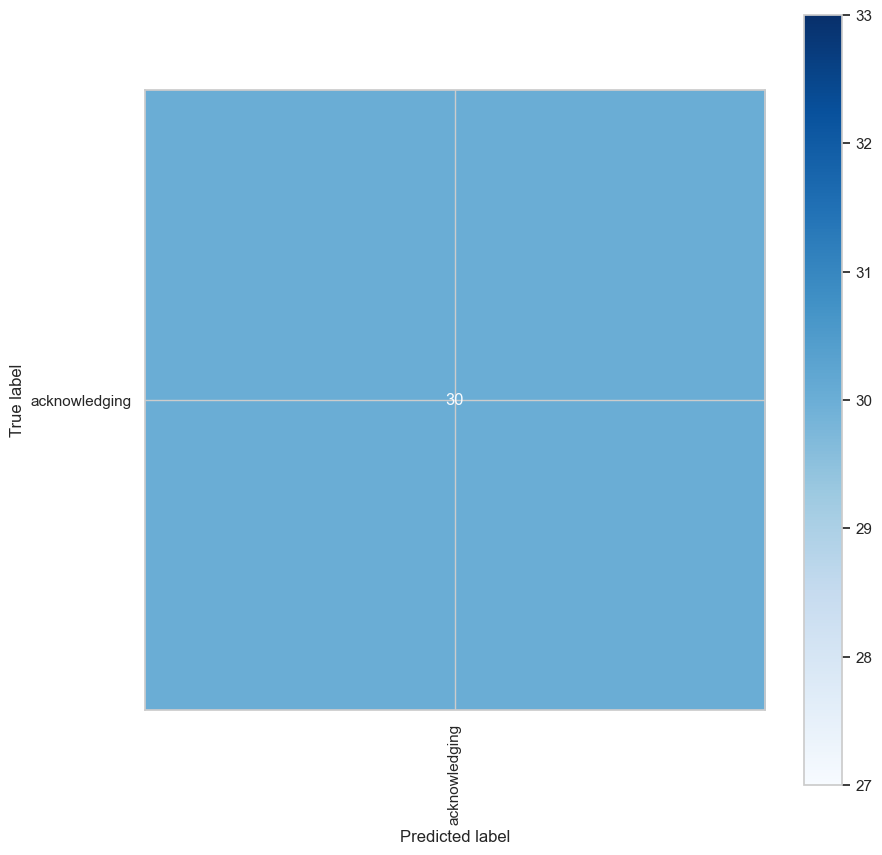

In [75]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay.from_predictions(x_edos, y_edos,
                                               ax=ax,
                                               xticks_rotation='vertical',
                                               cmap=plt.cm.Blues)

From the classification report we can observe different metrics for each emotion 

In [21]:
print(classification_report(x_edos, y_edos))

               precision    recall  f1-score   support

acknowledging       1.00      1.00      1.00        30

     accuracy                           1.00        30
    macro avg       1.00      1.00      1.00        30
 weighted avg       1.00      1.00      1.00        30


We can now chat with the bot and for each user input text the bot will predict the associated emotion. The top k emotions are also presented
This method takes user input text 

In [22]:
dialogue_edos_text(model_edos, agglomerate_edos, tokenizer, category_to_emotion)

USER: you are a monster.
BOT: acknowledging with prob: 0.9837114214897156
TOP 5: {'acknowledging': 0.9837114, 'ashamed': 0.0035525789, 'lonely': 0.0030955959, 'embarrassed': 0.0010845185, 'sad': 0.00096845377}
BYE!


We can now chat with the bot and for each user input text the bot will predict the associated emotion. The top k emotions are also presented
This method takes records the user's voice and produce a transcription. The whisper model is used to do so.

In [23]:
dialogue_edos_mic(model_edos, agglomerate_edos, tokenizer, category_to_emotion)

RECORDING IN... 3 2 1 RECORDING STARTED
121
USER: uh-uh
BOT: acknowledging with prob: 0.9783205986022949
TOP 5: {'acknowledging': 0.9783206, 'ashamed': 0.0044348957, 'lonely': 0.0039273994, 'embarrassed': 0.0014198468, 'sad': 0.001274094}


# BERT FINE TUNING (DO NOT RUN)
Instead of attaching additional layer and train them to perform emotion classification the hugging face library offers a AutoModelForSequenceClassification. Note that gradient is back-propagated though the entire pretrained model so it requires more computational power. Also in the previous section our method does not require saving all the weights.

In [24]:
train_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(X_train, y_train)]
eval_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(X_val, y_val)]
test_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(X_test, y_test)]

In [26]:
from datasets import Dataset as Dataset2
from datasets import DatasetDict

In [27]:
train_dataset = Dataset2.from_list(train_data)
test_dataset = Dataset2.from_list(eval_data)
val_dataset = Dataset2.from_list(test_data)

In [29]:
from transformers import AutoModelForSequenceClassification

bert = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=len(emotions_to_category),
                                                          id2label=category_to_emotion, label2id=emotions_to_category)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
data = DatasetDict()
data['train'] = train_dataset
data['validation'] = test_dataset
data['test'] = val_dataset

In [31]:
def tokenize_function(examples):
    global tokenizer
    return tokenizer(examples["text"], truncation=True)


tokenized_data = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

We use the Training Arguments and the Trainer from huggingface transformers

In [32]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

training_args = TrainingArguments(
    output_dir="FineTunedBertClassifier",
    num_train_epochs=20,
    learning_rate=1e-3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# Set Huggingface Trainer
trainer = Trainer(
    model=bert,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation'],
)


In [33]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=20, training_loss=0.31025118827819825, metrics={'train_runtime': 48.6399, 'train_samples_per_second': 23.026, 'train_steps_per_second': 0.411, 'total_flos': 21303008005440.0, 'train_loss': 0.31025118827819825, 'epoch': 20.0})

In [37]:
fine_tuned_prediction = trainer.predict(tokenized_data['test'])

In [43]:
fine_tuned_prediction.metrics

{'test_loss': 3.1232350011123344e-05,
 'test_runtime': 0.199,
 'test_samples_per_second': 150.752,
 'test_steps_per_second': 5.025}

In [48]:
preds = fine_tuned_prediction.label_ids

In [59]:
top_n = np.isin(preds, fine_tuned_prediction.predictions.argsort(axis=-1)[-5:][::-1])

In [60]:
fine_tuned_metrics = (y_test, preds, accuracy_score(y_test, preds), f1_score(y_test, preds, average='weighted'), top_n)


In [61]:
print_mean_metrics(fine_tuned_metrics)

MEAN ACCURACIES : 1.0
MEAN F1 SCORE   : 1.0
MEAN TOP 5 SCORE: 1.0


In [76]:
x_fine_tuned_edos, y_fine_tuned_edos = np.vectorize(lambda x: category_to_emotion[x])(fine_tuned_metrics[0]), \
    np.vectorize(lambda x: category_to_emotion[x])(fine_tuned_metrics[1])

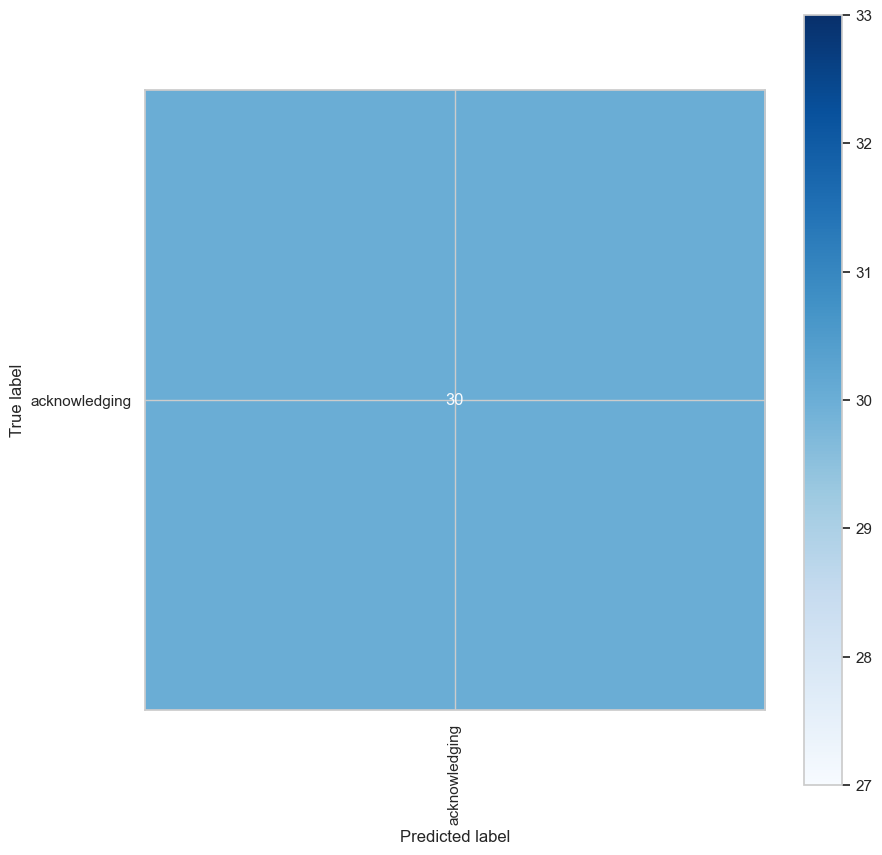

In [106]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay.from_predictions(x_fine_tuned_edos, y_fine_tuned_edos,
                                               ax=ax,
                                               xticks_rotation='vertical',
                                               cmap=plt.cm.Blues)

In [78]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


# Zero/Few-shot Learning (DO NOT RUN)
Here we explore another approach, we use the transformer pipeline to perform zero shot or few shot learning 

In [80]:
from transformers import pipeline

pipe = pipeline('zero-shot-classification', model='cross-encoder/nli-distilroberta-base', device=DEVICE,
                batch_size=BATCH_SIZE)

In [103]:
from tqdm.notebook import tqdm

zero_shot_out_labels = []
top_5_zero_shot = []
for i in tqdm(range(0, len(X_test), BATCH_SIZE)):
    to_feed = X_test[i:i + BATCH_SIZE].tolist()
    s = pipe(to_feed, candidate_labels=list(emotions_to_category.keys()))
    t = y_test[i:i + BATCH_SIZE].tolist()
    for j in range(0, len(s)):
        labels = np.array(s[j]['labels'])
        probs = np.array(s[j]['scores'])
        index = np.argsort(probs)[-5:][::-1]
        zero_shot_out_labels.append(probs.argmax())
        top_5_zero_shot.append(np.isin(probs.argmax(), index))

  0%|          | 0/1 [00:00<?, ?it/s]

In [104]:
# we compute and present the metrics in inference
zero_shot_metrics = (y_test, zero_shot_out_labels, accuracy_score(y_test, zero_shot_out_labels),
                     f1_score(y_test, zero_shot_out_labels, average='weighted'), top_5_zero_shot)

In [105]:
print_mean_metrics(zero_shot_metrics)

MEAN ACCURACIES : 1.0
MEAN F1 SCORE   : 1.0
MEAN TOP 5 SCORE: 1.0


In [107]:
x_zero_shot_edos, y_zero_shot_edos = np.vectorize(lambda x: category_to_emotion[x])(zero_shot_metrics[0]), \
    np.vectorize(lambda x: category_to_emotion[x])(zero_shot_metrics[1])

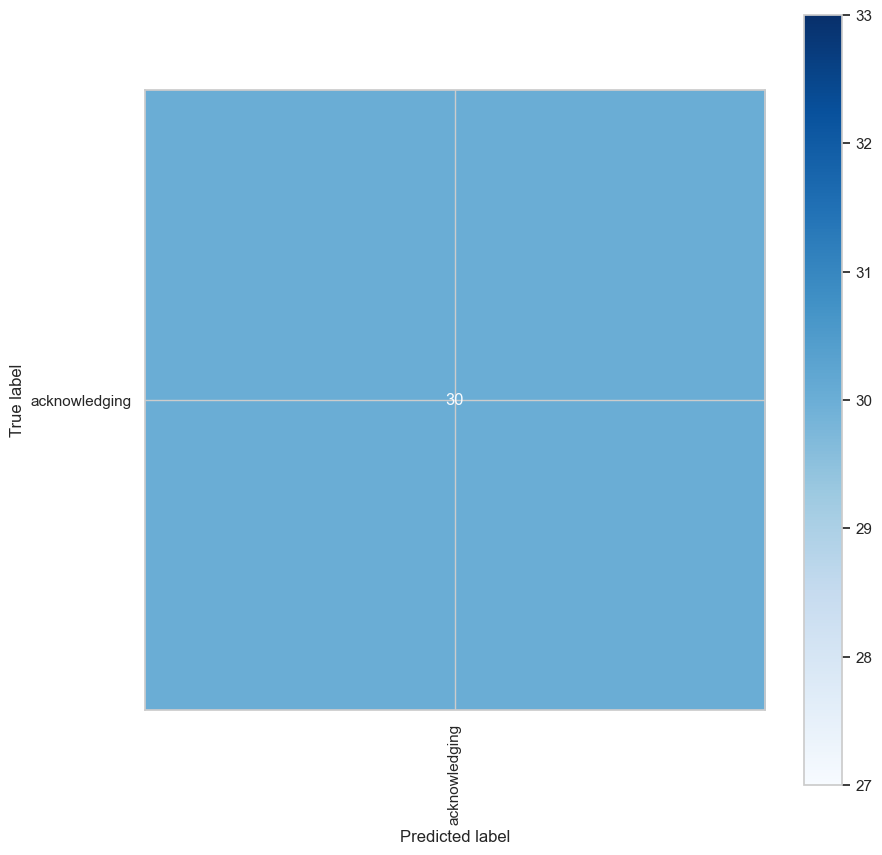

In [110]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay.from_predictions(x_zero_shot_edos, y_zero_shot_edos,
                                               ax=ax,
                                               xticks_rotation='vertical',
                                               cmap=plt.cm.Blues)

In [111]:
print(classification_report(x_zero_shot_edos, y_zero_shot_edos))

               precision    recall  f1-score   support

acknowledging       1.00      1.00      1.00        30

     accuracy                           1.00        30
    macro avg       1.00      1.00      1.00        30
 weighted avg       1.00      1.00      1.00        30


## Few-shot (DO NOT RUN)
We use the zero shot configuration but we sample examples from the training set and attach them to the text in inference.
The `insert_some_example` function sample some example in a balanced way and return them as text

In [115]:
df_train = pd.DataFrame({'X_train': X_train, 'y_train': np.vectorize(lambda x: category_to_emotion[x])(y_train)})
emotion_list = list(emotions_to_category.keys())


def row_to_text(row):
    return row['X_train'] + ' => ' + row['y_train']


df_train_copy = df_train.copy()
df_train_copy['X_train'] = df_train.apply(row_to_text, axis=1)
df_grouped = df_train_copy.groupby(by=['y_train'])


def insert_some_example(n_shot=len(emotion_list), g=12):
    global df_grouped, emotion_list
    repeat = n_shot // len(emotion_list)
    if repeat == 0:
        repeat = 1
    t = df_grouped.sample(n=repeat, replace=False, random_state=g).loc[:, 'X_train'].to_numpy(dtype=str)
    index = np.random.default_rng(g).choice(range(len(t)), replace=False, size=n_shot)
    t = t[index]
    return '\n'.join(t)


In [125]:
def few_shot_learning(n_shot):
    print_seq = True
    out_labels = []
    top_5 = []
    with torch.no_grad():
        for i in tqdm(range(0, len(X_test), BATCH_SIZE)):
            if i > 10 * BATCH_SIZE:
                print_seq = False
            to_feed = X_test[i:i+BATCH_SIZE].tolist()
            for j in range(0, len(to_feed)):
                to_feed[j] = insert_some_example(n_shot, i+j) + '\n' + to_feed[j] + ' =>'
            s = pipe(to_feed, candidate_labels=emotion_list)
            t = [category_to_emotion[c] for c in y_test[i:i+BATCH_SIZE]]
            if print_seq:
                print(f'SEQUENCE {i}: ', s[0]['sequence'])
                print(f'TRUE LABEL:', t[0])
            for j in range(0, len(s)):
                labels = np.array(s[j]['labels'])
                probs = np.array(s[j]['scores'])
                index = np.argsort(probs)[-5:][::-1]
                out_labels.append(probs.argmax())
                top_5.append(t[j] in labels[index])
            if print_seq:
                print(f'TOP 5: {labels[index]} with probs: {probs[index]}\n\n')
    return out_labels , top_5      

In [129]:
few_shot_learning_out_labels, top_5_few_shot = few_shot_learning(1)

  0%|          | 0/1 [00:00<?, ?it/s]

SEQUENCE 0:  Khyber , wow . => acknowledging
Khyber , wow . => acknowledging
Shizuka ! => =>
TRUE LABEL: acknowledging
TOP 5: ['acknowledging' 'prepared' 'suggesting' 'content' 'agreeing'] with probs: [0.26640582 0.1007853  0.09412713 0.04416276 0.03682113]


In [130]:
few_shot_metrics = (y_test, few_shot_learning_out_labels, accuracy_score(y_test, few_shot_learning_out_labels), f1_score(y_test, few_shot_learning_out_labels, average='weighted'), top_5_few_shot)

In [131]:
print_mean_metrics(few_shot_metrics)

MEAN ACCURACIES : 1.0
MEAN F1 SCORE   : 1.0
MEAN TOP 5 SCORE: 0.9666666666666667


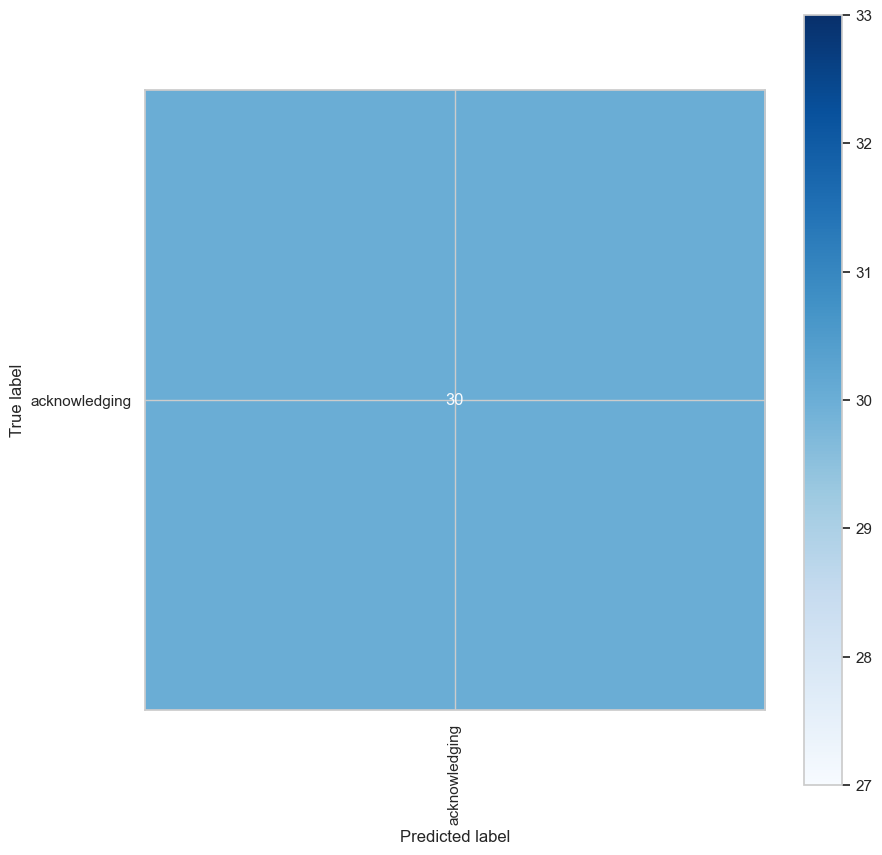

In [132]:
x_few_shot_edos, y_few_shot_edos = np.vectorize(lambda x: category_to_emotion[x])(few_shot_metrics[0]), \
    np.vectorize(lambda x: category_to_emotion[x])(few_shot_metrics[1])
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay.from_predictions(x_few_shot_edos, y_few_shot_edos,
                                               ax=ax,
                                               xticks_rotation='vertical',
                                               cmap=plt.cm.Blues)

In [133]:
print(classification_report(x_few_shot_edos, y_few_shot_edos))

               precision    recall  f1-score   support

acknowledging       1.00      1.00      1.00        30

     accuracy                           1.00        30
    macro avg       1.00      1.00      1.00        30
 weighted avg       1.00      1.00      1.00        30


# AUDIO-TEXT 
Here we explore and combine different approaches. To be precise we explore how the model performs when audio features are included.
# Speech to emotion

For this part of the project we used the dataset "IEMOCAP: Interactive emotional dyadic motion capture database."
The dataset contains conversations audio, transcription, video and motion-capture.
We discarded the transcription, video and motion-capture features and we used only the audio.

We performed a transcription of the audio using Whisper.

In [ ]:
speech_to_text = whisper.load_model("base.en", in_memory=True)
def parse_audio(path):
    audio = whisper.load_audio(path)
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).to(speech_to_text.device)
    options = whisper.DecodingOptions(fp16=False, language="en")
    result = whisper.decode(speech_to_text, mel, options)
    text = result.text
    return [text, mel]

In [ ]:
sessions = ["Session1","Session2","Session3","Session4", "Session5"]
missing_sessions = []
for i in sessions:
    if not os.path.exists(f"./{i}.pkl"):
        missing_sessions.append(i)

for i in missing_sessions:
    dir = f"./{i}/dialog/EmoEvaluation/"
    files = os.listdir(dir)
    files_dictionary = {}
    for i in os.listdir(dir):
        if i.endswith(".txt"):
            file = open(dir + i, "r")
            for line in file:
                if line.startswith("["):
                    line = line.split()
                    path = "_".join(line[3].split("_")[:-1])
                    if path in files_dictionary:
                        files_dictionary[path][line[3]] = [line[4]]
                    else:
                        files_dictionary[path] = {line[3]: [line[4]]}
            file.close()
    audio_path = f"./{i}/sentences/wav/"
    for key in tqdm(files_dictionary):
        for file in files_dictionary[key]:
            path = audio_path + key + "/" + file + ".wav"
            files_dictionary[key][file] = files_dictionary[key][file] + parse_audio(path)
    print(f"Saving {i}")
    pickle.dump(files_dictionary, open(f"{i}.pkl", "wb"))
    

In [ ]:
session1 = pickle.load(open("Session1.pkl", "rb"))
session2 = pickle.load(open("Session2.pkl", "rb"))
session3 = pickle.load(open("Session3.pkl", "rb"))
session4 = pickle.load(open("Session4.pkl", "rb"))
session5 = pickle.load(open("Session5.pkl", "rb"))

# Data analysis

We are only interested in emotions that are clearly identifiable.
We proceeded in removing emotions that are not common and we removed al the emotions flagged as "other".

In [ ]:
emotions = {}
for i in [session1, session2, session3, session4, session5]:
    for j in i.keys():
        for k in i[j].keys():
            if i[j][k][0] not in emotions.keys():
                emotions[i[j][k][0]] = 1
            else:
                emotions[i[j][k][0]] += 1
print("All emotions")
print("-" * 50)
for i in emotions.keys():
    print(i, emotions[i])
print("-" * 50)

print("filtered emotions")
print("-" * 50)
emotions_to_remove = []
for i in emotions.keys():
    if emotions[i] < 150:
        emotions_to_remove.append(i)
        emotions["xxx"] += emotions[i]
for i in emotions_to_remove:
    del emotions[i]
for i in emotions.keys():
    print(i, emotions[i])
print("-" * 50)
for i in [session1, session2, session3, session4, session5]:
    for j in i.keys():
        for k in i[j].keys():
            if i[j][k][0] in emotions_to_remove:
                i[j][k][0] = "xxx"
emotions = {}
for i in [session1, session2, session3, session4, session5]:
    for j in i.keys():
        for k in i[j].keys():
            if i[j][k][0] not in emotions.keys():
                emotions[i[j][k][0]] = 1
            else:
                emotions[i[j][k][0]] += 1

In [ ]:
all_data = []
for i in [session1, session2, session3, session4, session5]:
    for j in i.keys():
        for k in i[j].keys():
            if i[j][k][0] != "xxx":
                all_data.append(i[j][k])
print("Total data points", len(all_data))

# Model

As in the previous part we extracted features from the text using BERT, we are using the output of the last four layers of the model and we are combining them together as input to the part of the network responsible for the text.
For the part of the model responsible in extracting information from the audio we pass the mel spectrogram.

In [ ]:
class TextAudioDataloader(Dataset):
    def __init__(self, text_model, tokenizer, data):
        self.text_model = text_model
        self.tokenizer = tokenizer
        self.data = data
        self.emotion_to_one_hot = {
            "ang": torch.tensor([1, 0, 0, 0, 0, 0], dtype=torch.float32),
            "fru": torch.tensor([0, 1, 0, 0, 0, 0], dtype=torch.float32),
            "neu": torch.tensor([0, 0, 1, 0, 0, 0], dtype=torch.float32),
            "sad": torch.tensor([0, 0, 0, 1, 0, 0], dtype=torch.float32),
            "exc": torch.tensor([0, 0, 0, 0, 1, 0], dtype=torch.float32),
            "hap": torch.tensor([0, 0, 0, 0, 0, 1], dtype=torch.float32),
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        with torch.no_grad():
            emotion, text, audio = self.data[idx]
            encoded_input = self.tokenizer(text, return_tensors="pt").to(
                self.text_model.device
            )
            output_text_features = self.text_model(**encoded_input)
            all_hidden_states = torch.stack(output_text_features["hidden_states"])
            concatenate_pooling = torch.cat(
                (
                    all_hidden_states[-1],
                    all_hidden_states[-2],
                    all_hidden_states[-3],
                    all_hidden_states[-4],
                ),
                -1,
            )
            concatenate_pooling = concatenate_pooling[:, 0]
            return (
                concatenate_pooling.squeeze(0).float(),
                audio.unsqueeze(0),
                self.emotion_to_one_hot[emotion],
            )

In [ ]:
config = AutoConfig.from_pretrained("bert-base-uncased")
config.update({"output_hidden_states": True})
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", config=config)
text_to_embeddings = AutoModel.from_pretrained(
    "bert-base-uncased", config=config, torch_dtype=torch.float16
)
text_to_embeddings = text_to_embeddings.to(DEVICE)

In [ ]:
dataset = TextAudioDataloader(text_to_embeddings, tokenizer, all_data)
train_dataset, validation_dataset, test_dataset = random_split(
    dataset, [0.7, 0.2, 0.1]
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Here we define the Audio and text model, text and audio flags allows us to produce different combinations 

In [ ]:
class AudioAndTextModel(pl.LightningModule):
    def __init__(self, num_classes, dropout=0.0, text=False, audio=False, probability_removing_audio=0.0):
        super().__init__()
        self.save_hyperparameters()
        self.num_classes = num_classes
        self.text = text
        self.audio = audio
        self.probability_removing_audio = probability_removing_audio

        if audio:
            self.audio_model = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2)),
                nn.SiLU(),
                nn.MaxPool2d(kernel_size=(4, 4)),
                nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)),
                nn.SiLU(),
                nn.MaxPool2d(kernel_size=(4, 4)),
                nn.Flatten(),
                nn.Linear(1472, 512),
                nn.Dropout(dropout),
                nn.SiLU(),
                nn.Linear(512, 256),
                nn.Dropout(dropout),
                nn.SiLU(),
            )

        if text:
            self.text_linear = nn.Sequential(
                nn.Linear(3072, 256),
                nn.Dropout(dropout),
                nn.SiLU(),
            )

        if text and audio:
            self.linear = nn.Sequential(
                nn.Linear(512, 256),
                nn.Dropout(dropout),
                nn.SiLU(),
                nn.Linear(256, num_classes),
            )
        else:
            self.linear = nn.Sequential(
                nn.Linear(256, num_classes),
            )

    def forward(self, audio, text):
        if self.text and not self.audio:
            features = self.text_linear(text)
        elif self.audio and not self.text:
            features = self.audio_model(audio)
        else:
            text_features = self.text_linear(text)
            if random.random() < self.probability_removing_audio and self.training:
                audio_features = torch.zeros_like(text_features)
            else:
                audio_features = self.audio_model(audio)
            features = torch.cat((audio_features, text_features), dim=1)

        return self.linear(features)

    def training_step(self, batch, batch_idx):
        text, audio, labels = batch
        logits = self(audio, text)

        loss = F.cross_entropy(logits, labels, label_smoothing=0.3)
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )

        accuracy = self.accuracy(logits, labels)
        self.log(
            "train_acc",
            accuracy,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        text, audio, labels = batch
        logits = self(audio, text)

        loss = F.cross_entropy(logits, labels)
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )

        accuracy = self.accuracy(logits, labels)
        self.log(
            "val_acc", accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        top_2_accuracy = self.top_k_accuracy(logits, labels, k=2)
        self.log(
            "val_top_2_acc", top_2_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
    
    def test_step(self, batch, batch_idx):
        text, audio, labels = batch
        logits = self(audio, text)

        loss = F.cross_entropy(logits, labels)
        self.log(
            "test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )

        accuracy = self.accuracy(logits, labels)
        self.log(
            "test_acc", accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )

        top_2_accuracy = self.top_k_accuracy(logits, labels, k=2)
        self.log(
            "test_top_2_acc", top_2_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
    
    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        text, audio, labels = batch
        logits = self(audio, text)
        return torch.softmax(logits, dim=1)

    def accuracy(self, logits, labels):
        return torch.sum(
            torch.argmax(logits, dim=1) == torch.argmax(labels, dim=1)
        ).item() / len(labels)
    
    def top_k_accuracy(self, logits, labels, k=2):
        y_true = torch.argmax(labels, dim=1).detach().cpu().numpy()
        y_pred = logits.detach().cpu().numpy()
        y_pred = np.argsort(y_pred, axis=-1)[:, -k:]
        return np.mean(np.isin(y_true[:, np.newaxis], y_pred))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-4)
        return optimizer

# MODEL ONLY WITH TEXT

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

model_only_text = AudioAndTextModel(6, text=True)
early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=10)
checkpoint_callback_only_text = ModelCheckpoint(
    dirpath="checkpoints",
    filename="{epoch}-{val_acc:.2f}-{val_loss:.2f}.ckpt",
    save_top_k=1,
    monitor="val_acc",
    mode="max",
    save_last=True,
)
trainer_only_text = pl.Trainer(
    accelerator=DEVICE.type,
    max_epochs=1000,
    accumulate_grad_batches=4,
    callbacks=[early_stopping, checkpoint_callback_only_text],
)

trainer_only_text.fit(model_only_text, train_loader, test_loader)
trainer_only_text.test(ckpt_path=checkpoint_callback_only_text.best_model_path, dataloaders=test_loader, verbose=True)

## MODEL ONLY WITH AUDIO

In [ ]:
model_only_audio = AudioAndTextModel(6, audio=True)
early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=10)
checkpoint_callback_only_audio = ModelCheckpoint(
    dirpath="checkpoints_audio",
    filename="{epoch}-{val_acc:.2f}-{val_loss:.2f}.ckpt",
    save_top_k=1,
    monitor="val_acc",
    mode="max",
    save_last=True,
)
trainer_only_audio = pl.Trainer(
    accelerator=DEVICE.type,
    max_epochs=1000,
    accumulate_grad_batches=4,
    callbacks=[early_stopping, checkpoint_callback_only_audio],
)

trainer_only_audio.fit(model_only_audio, train_loader, test_loader)
trainer_only_audio.test(ckpt_path=checkpoint_callback_only_audio.best_model_path, dataloaders=test_loader, verbose=True)

## MODEL WITH BOTH AUDIO AND TEXT

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

model_both = AudioAndTextModel(6, audio=True, text=True)
early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=10)
checkpoint_callback_both = ModelCheckpoint(
    dirpath="checkpoints_audio_text",
    filename="{epoch}-{val_acc:.2f}-{val_loss:.2f}.ckpt",
    save_top_k=1,
    monitor="val_acc",
    mode="max",
    save_last=True,
)
trainer_both = pl.Trainer(
    accelerator=DEVICE.type,
    max_epochs=1000,
    accumulate_grad_batches=4,
    callbacks=[early_stopping, checkpoint_callback_both],
)

trainer_both.fit(model_both, train_loader, test_loader)
trainer_both.test(ckpt_path=checkpoint_callback_both.best_model_path, dataloaders=test_loader, verbose=True)

# MODEL WITH TEXT AND AUDIO MASKING

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

model_mask = AudioAndTextModel(6, audio=True, text=True, probability_removing_audio=0.2)
early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=10)
checkpoint_callback_mask = ModelCheckpoint(
    dirpath="checkpoints_audio_text_prob_0.2",
    filename="{epoch}-{val_acc:.2f}-{val_loss:.2f}.ckpt",
    save_top_k=1,
    monitor="val_acc",
    mode="max",
    save_last=True,
)
trainer_mask = pl.Trainer(
    accelerator=DEVICE.type,
    max_epochs=1000,
    accumulate_grad_batches=4,
    callbacks=[early_stopping, checkpoint_callback_mask],
)

trainer_mask.fit(model_mask, train_loader, test_loader)
trainer_mask.test(ckpt_path=checkpoint_callback_mask.best_model_path, dataloaders=test_loader, verbose=True)

In [ ]:
record_to_file("only_text.wav")

model_input = parse_audio("only_text.wav")
model_input = [""]+model_input

data_input = TextAudioDataloader(text_to_embeddings, tokenizer, [model_input])
user_input_loader = DataLoader(data_input, batch_size=1, shuffle=False)

trainer_only_text.predict(dataloaders=user_input_loader, ckpt_path=checkpoint_callback_mask.best_model_path)